# <span style="color:darkred"> Laboratorio di Simulazione Numerica </span>
## <span style="color:darkorange">  Esercitazione 7</span>

## 07.1

In questa esercitazione ho utilizzato il codice *MonteCarlo NVT* già fornitoci per simulare il comportamento delle particelle confinate in un box in *ensamble* canonico. Tale codice sfrutta il metodo di Metropolis, usando il peso di Boltzmann, per campionare le posizioni successive delle particelle e in questo modo non sto simulando una traiettoria ma solo posizioni differenti. Usando un modello di Lennard-Jones il codice stima l'energia potenziale e la pressione e contiene anche le *tail corrections* per tali quantità. Le simulazioni precedenti infatti valutavano le grandezze termodinamiche entro un raggio sferico di *cut-off* scritto come $r_{c}$ e quindi le correzioni servono a compensare l'interazione a lungo range del potenziale.

Ho aggiunto al codice all'interno della funzione *Measure* la capacità di stampare i valori istantanei dell'energia potenziale per particella e della pressione. Prima di prendere le misure ho equilibrato le simulazioni Monte Carlo e anche il campionamento di Metropolis per avere un'accettazione del $50\%$. Ho considerato tre diverse fasi dell'Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu):
- solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
- liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
- gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

Ho creato tre file di *input* a seconda della fase da simulare e prima di passare alla fase successiva è necessario nel *main* cambiare il file di *input* da leggere commentando quello precedente. Ho quindi regolato a mano l'accettazione del Metropolis modificando il valore di $\delta$ dato in input, che rappresenta di quanto ci si muove facendo un passo. Per la fase solida ho posto $\delta=0.1$ ottenendo un'accettazione pari circa a $0.54$; per la fase liquida $\delta=0.2$ con l'accettazione di circa $0.52$; per il gas ho $\delta=5$ con un'accettazione di $0.63$. Il passo è crescente passando dal solido al gas, infatti un sistema allo stato solido è più compatto e denso, quindi per campionare una nuova posizione basta fare un piccolo passo. Nella fase gassosa le particelle sono così distanti a causa della bassa densità che per misurare un'energia diversa occorre muoversi più lontano.

Una volta regolata l'accettazione ho equilibrato il sistema. Dopo $1000$ passi le grandezze misurate smettono di fare brusche oscillazioni e si stabilizzano attorno a un valore medio. Allora ho effettuato una simulazione da un migliaio di step con la configurazione iniziale di reticolo FCC copiandola nel file *config.0*, letto dalla funzione *Input* all'inzio del codice. Successivamente ho copiato la configurazione finale nel file *config.0* e ho rieseguito la simulazione, misurando le grandezze equilibrate.

Ho eseguito una simulazione per ogni fase da $5\times10^5$ step Monte Carlo con un blocco solo e ho calcolato la funzione di autocorrelazione sia per l'energia potenziale sia per la pressione servendomi della seguente equazione:

$$ AC(t') = \frac{\left\langle m(t)m(t+t') \right\rangle - \left\langle m(t) \right\rangle\left\langle m(t+t') \right\rangle}{\sigma^2_m}\ .$$

Tale funzione defisce quanto sono correlate le grandezze che differiscono di un tempo $t'$, dove $1t'$ è da considerare come uno step Monte Carlo. Due step Monte Carlo vicini danno grandezze molto correlate. Ho riportato un grafico della funzione di autocorrelazione in funzione del numero di step. Oltre $200$ step Monte Carlo le misure sono scorrelate poichè la funzione tende a zero. Ho calcolato i tempi di correlazione $t_c$ e in generale per avere un insieme di punti veramente indipendenti occorre campionarli a intervalli pari a circa $2t_c$.

In seguito ho utilizzato le stesse misure per valutare come cambiasse l'errore in funzione del numero di step contenuti in ciascun blocco. Ciò risulta utile nel momento in cui bisogna decidere quanto grossi fare i blocchi quando si fa la media. Ho calcolato l'errore tramite uno script su Python. Dai grafici riportati ho osservato che da $L=2\times10^3$ in poi per solido e liquido l'errore si stabilizza e non varia di molto. Questo ci suggerisce di fare circa un migliaio di misure per blocco. Per il gas l'errore della pressione continua a crescere e a cambiare, mentre quello sull'energia potenziale descresce bruscamente da $L=2\times10^3$ in poi. Ho deciso di considerare $50$ blocchi di lunghezza $10^3$ in tutte e tre le fasi.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import math
from scipy import stats
from scipy.optimize import curve_fit

In [46]:
Epot_s = np.loadtxt('MonteCarlo_NVT/solid/inst_epot.dat', unpack=True, usecols=(0))
Pres_s = np.loadtxt('MonteCarlo_NVT/solid/inst_pres.dat', unpack=True, usecols=(0))
Epot_l = np.loadtxt('MonteCarlo_NVT/liquid/inst_epot.dat', unpack=True, usecols=(0))
Pres_l = np.loadtxt('MonteCarlo_NVT/liquid/inst_pres.dat', unpack=True, usecols=(0))
Epot_g= np.loadtxt('MonteCarlo_NVT/gas/inst_epot.dat', unpack=True, usecols=(0))
Pres_g = np.loadtxt('MonteCarlo_NVT/gas/inst_pres.dat', unpack=True, usecols=(0))

In [47]:
# Funzione di AUTOCORRELAZIONE

def AC(m, tmax):
    N = len(m)
    m_av = 0.
    m2_av = 0.
    for i in range(0,N):
        m_av += m[i]
        m2_av += m[i]*m[i]
    m_av = m_av/N
    m2_av = m2_av/N
    sigma2 = m2_av - m_av*m_av
    
    auto = np.zeros(tmax)
    m1 = np.zeros(tmax) #sum(m(t')*m(t'+t)) per ogni t
    m2 = np.zeros(tmax) #sum(m(t'))
    m3 = np.zeros(tmax) #sum(m(t'+t))
    for t in range(0,tmax):
        for j in range(0,N-t):
            m1[t] += m[j]*m[j+t]
            m2[t] += m[j]
            m3[t] += m[j+t]
        m1[t] = m1[t]/(N-t)
        m2[t] = m2[t]/(N-t)
        m3[t] = m3[t]/(N-t)
        auto[t] = (m1[t] - m2[t]*m3[t])/sigma2
    
    return auto

In [48]:
AC_Epot_s = AC(Epot_s, 500)
AC_Pres_s = AC(Pres_s, 500)

AC_Epot_l = AC(Epot_l, 500)
AC_Pres_l = AC(Pres_l, 500)

AC_Epot_g = AC(Epot_g, 500)
AC_Pres_g = AC(Pres_g, 500)

l = len(AC_Epot_s)
x = np.linspace(0, l, l)

Solid - Energy correlation time = 10.776471715467173
Solid - Pressure correlation time = 10.551236779466478

Liquid - Energy correlation time = 18.18724046062654
Liquid - Pressure correlation time = 24.993680004865546

Gas - Energy correlation time = 2.922922816310282
Gas - Pressure correlation time = 0.8622130486307344


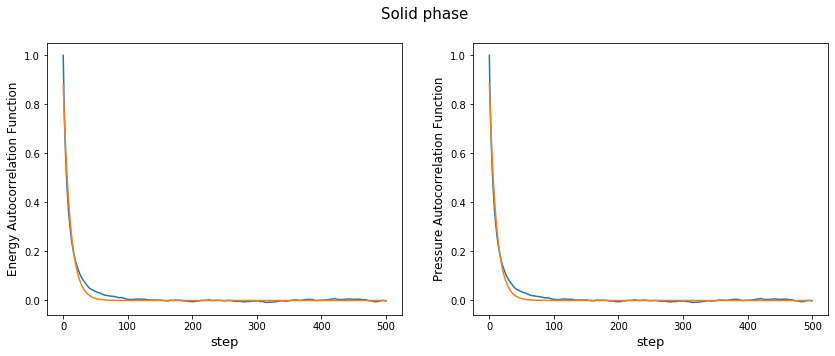

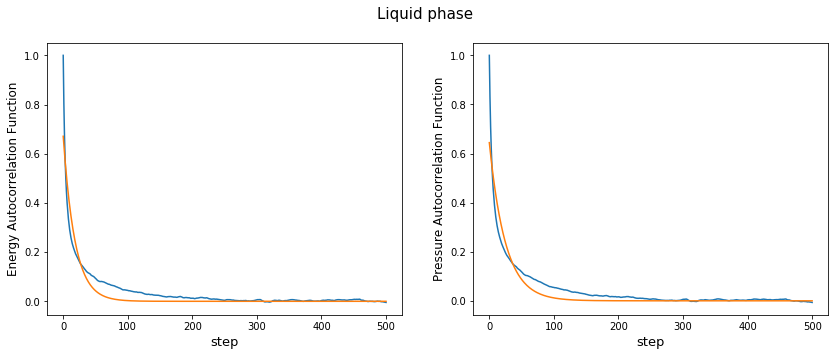

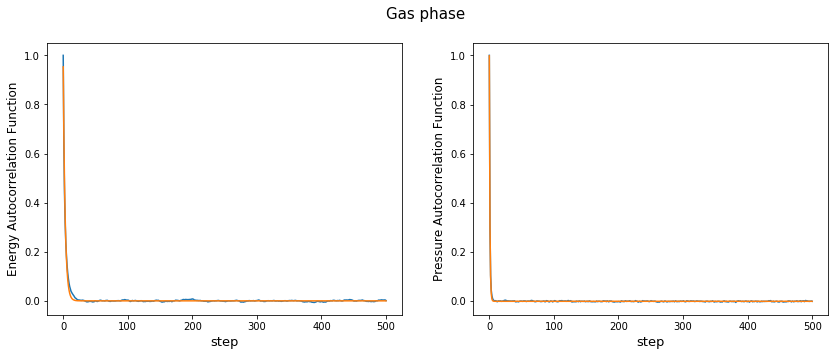

In [50]:
def test_func(x, a, b):
    return a*np.exp(-x/b)

fig, axs = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Solid phase', fontsize=15)
axs[0].plot(x, AC_Epot_s)
p_opt, p_cov = curve_fit(test_func,x,AC_Epot_s)
axs[0].plot(x, test_func(x, p_opt[0],p_opt[1]))
print('Solid - Energy correlation time =', p_opt[1])
axs[0].set_ylabel('Energy Autocorrelation Function', fontsize=12)
axs[1].plot(x, AC_Pres_s)
p_opt, p_cov = curve_fit(test_func,x,AC_Pres_s)
axs[1].plot(x, test_func(x, p_opt[0],p_opt[1]))
print('Solid - Pressure correlation time =', p_opt[1])
axs[1].set_ylabel('Pressure Autocorrelation Function', fontsize=12)
print()

fig1, axs1 = plt.subplots(1, 2, figsize=(14,5))
fig1.suptitle('Liquid phase', fontsize=15)
axs1[0].plot(x, AC_Epot_l)
p_opt, p_cov = curve_fit(test_func,x,AC_Epot_l)
axs1[0].plot(x, test_func(x, p_opt[0],p_opt[1]))
print('Liquid - Energy correlation time =', p_opt[1])
axs1[0].set_ylabel('Energy Autocorrelation Function', fontsize=12)
axs1[1].plot(x, AC_Pres_l)
p_opt, p_cov = curve_fit(test_func,x,AC_Pres_l)
axs1[1].plot(x, test_func(x, p_opt[0],p_opt[1]))
print('Liquid - Pressure correlation time =', p_opt[1])
axs1[1].set_ylabel('Pressure Autocorrelation Function', fontsize=12)
print()

fig2, axs2 = plt.subplots(1, 2, figsize=(14,5))
fig2.suptitle('Gas phase', fontsize=15)
axs2[0].plot(x, AC_Epot_g)
p_opt, p_cov = curve_fit(test_func,x,AC_Epot_g)
axs2[0].plot(x, test_func(x, p_opt[0],p_opt[1]))
print('Gas - Energy correlation time =', p_opt[1])
axs2[0].set_ylabel('Energy Autocorrelation Function', fontsize=12)
axs2[1].plot(x, AC_Pres_g)
p_opt, p_cov = curve_fit(test_func,x,AC_Pres_g)
axs2[1].plot(x, test_func(x, p_opt[0],p_opt[1]))
print('Gas - Pressure correlation time =', p_opt[1])
axs2[1].set_ylabel('Pressure Autocorrelation Function', fontsize=12)

for ax in axs.flat:
    ax.set_xlabel('step', fontsize=13)
for ax in axs1.flat:
    ax.set_xlabel('step', fontsize=13)
for ax in axs2.flat:
    ax.set_xlabel('step', fontsize=13)

In [51]:
def Blocking_err(m, M, N):
    L=(int)(M/N)
    m_av=0.
    m2_av=0.
    m_prog=0.
    m2_prog=0.
    err=0.
    
    for i in range(N):
        m_av = 0
        for j in range(L):
            k = j+i*L
            m_av += m[k]/L
        m_prog += m_av
        m2_prog += (m_av)**2 

    err = ((m2_prog/(N)-m_prog*m_prog/(N*N))/(N-1))**0.5    
    
    return err   

In [52]:
M = 500000
N = np.array([50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])
L = np.zeros(len(N))

err_epot_s = np.zeros(len(N))
err_pres_s = np.zeros(len(N))
err_epot_l = np.zeros(len(N))
err_pres_l = np.zeros(len(N))
err_epot_g = np.zeros(len(N))
err_pres_g = np.zeros(len(N))

t=0
for i in N: 
    err_epot_s[t] = Blocking_err(Epot_s, M, i)
    err_pres_s[t] = Blocking_err(Pres_s, M, i)
    err_epot_l[t] = Blocking_err(Epot_l, M, i)
    err_pres_l[t] = Blocking_err(Pres_l, M, i)
    err_epot_g[t] = Blocking_err(Epot_g, M, i)
    err_pres_g[t] = Blocking_err(Pres_g, M, i)
    L[t] = (int)(M/i)
    t=t+1

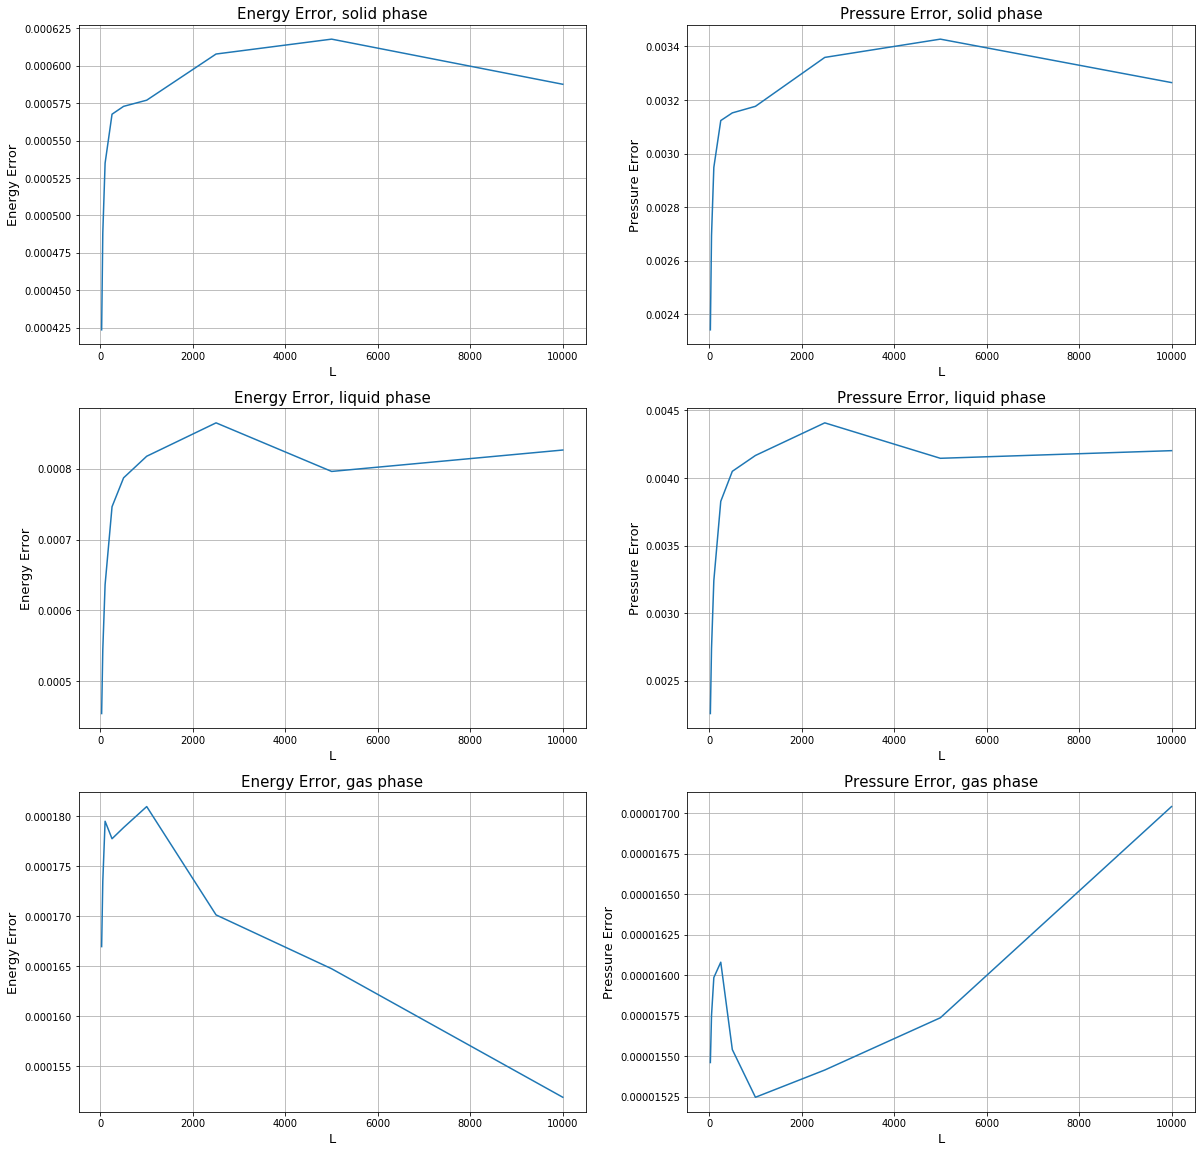

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

axs[0,0].plot(L, err_epot_s)
axs[0,0].set_ylabel('Energy Error', fontsize=13)
axs[0,0].set_title('Energy Error, solid phase', fontsize=15)

axs[0,1].plot(L, err_pres_s)
axs[0,1].set_ylabel('Pressure Error', fontsize=13)
axs[0,1].set_title('Pressure Error, solid phase', fontsize=15)

axs[1,0].plot(L, err_epot_l)
axs[1,0].set_ylabel('Energy Error', fontsize=13)
axs[1,0].set_title('Energy Error, liquid phase', fontsize=15)

axs[1,1].plot(L, err_pres_l)
axs[1,1].set_ylabel('Pressure Error', fontsize=13)
axs[1,1].set_title('Pressure Error, liquid phase', fontsize=15)

axs[2,0].plot(L, err_epot_g)
axs[2,0].set_ylabel('Energy Error', fontsize=13)
axs[2,0].set_title('Energy Error, gas phase', fontsize=15)

axs[2,1].plot(L, err_pres_g)
axs[2,1].set_ylabel('Pressure Error', fontsize=13)
axs[2,1].set_title('Pressure Error, gas phase', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel('L', fontsize=13)
    ax.grid()

## 07.2 - 07.3

Ho implementato il calcolo per la funzione di distribuzione radiale $g(r)$. Essa rappresenta la probabilotà di trovare una coppia di particelle la cui distanza è $r$ ed è definita come
$$ g(r) = \frac{1}{\rho N \Delta V(r)} \left\langle \sum \sum_{i \not= j = 1}^N \delta \bigl[\bigl|\vec{r}\bigr|-\bigl|(\vec{r}_i-\vec{r}_j)\bigr|\bigr] \right\rangle\ ,$$
con
$$ \Delta V (r) = \frac{4}{3} \pi \bigl[(r+dr)^3-r^3 \bigr]\ .$$

Ho considerato solo distanze $dr<L/2$ (con $L$ lato della cella) per essere sicura di considerare due particelle contenute all'interno della cella. Per calcolare $g(r)$ ho riempito un istogramma di $100$ bin di dimensione $\frac{L/2}{100}$. Ad ogni coppia di particelle è associata una distanza $dr$, alla quale a sua volta è associato un bin che ho incrementato di $2$ ogni volta che fossero trovate due particelle alla distanza a cui esso corrispondeva. In seguito ho inserito tale procedura anche all'interno del codice che simula la dinamica molecolare in ensamble microcanico utilizzato nell'esercitazione $4$.

## 07.4

Ho eseguito la simulazione equilibrando il sistema nella fase iniziale. I grafici che ho riportato rappresentano la media dell'energia e della pressione in funzione dei blocchi. Per quanto riguarda la funzione $g(r)$, ho riportato la media dell'ultimo blocco calcolata per ogni bin in funzione della distanza ad esso associata. Inoltre ho confrontato i risultati ottenuti dall'algoritmo *Monte Carlo NVT* con quelli ottenuti dalla simulazione della dinamica molecolare e ho osservato una perfetta sovrapposizione nella fase liquida e solida. La $g(r)$ non si sovrappone bene nella fase gassosa e il risultato ottenuto dalla dinamica molecolare presenta degli errori più grandi rispetto alle altre due fasi. Ho pensato che un problema di questo tipo potesse essere dovuto alla non totale equilibrazione del gas.

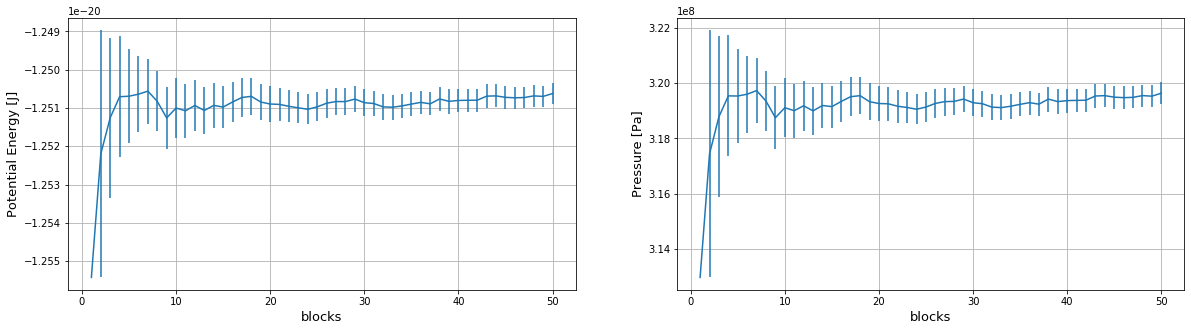

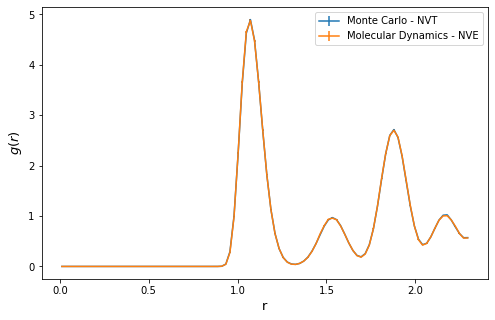

In [3]:
epsilon_kB = 120. #kelvin
kb = 1.380649*(10.**(-23))
epsilon = epsilon_kB*kb

sigma = 0.34*(10**(-9))
fatt_pres = epsilon/(sigma**3)

(blk, Epot_s, errEpot_s) = np.loadtxt('MonteCarlo_NVT/solid/output.epot.0', unpack=True, usecols=(0, 2, 3))
Epot_s = Epot_s*epsilon
errEpot_s = errEpot_s*epsilon

(blk, Pres_s, errPres_s) = np.loadtxt('MonteCarlo_NVT/solid/output.pres.0', unpack=True, usecols=(0, 2, 3))
Pres_s = Pres_s*fatt_pres
errPres_s = errPres_s*fatt_pres

(r_s, gdir_s, errGdir_s) = np.loadtxt('MonteCarlo_NVT/solid/output.gave.0', unpack=True, usecols=(1, 2, 3))
(r_s_MD, gdir_s_MD, errGdir_s_MD) = np.loadtxt('../Exercise04/MolecularDynamics_NVE/solid/ave_gave.dat', unpack=True, usecols=(1, 2, 3))

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].errorbar(blk, Epot_s, yerr=errEpot_s)
axs[0].set_ylabel('Potential Energy [J]', fontsize=13)
axs[1].errorbar(blk, Pres_s, yerr=errPres_s)
axs[1].set_ylabel('Pressure [Pa]', fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('blocks', fontsize=13)
    ax.grid()

plt.figure(figsize=(8, 5))
plt.errorbar(r_s, gdir_s, yerr=errGdir_s, label = 'Monte Carlo - NVT')
plt.errorbar(r_s_MD, gdir_s_MD, yerr=errGdir_s_MD, label = 'Molecular Dynamics - NVE')
plt.ylabel('$g(r)$', fontsize=13)
plt.xlabel('r', fontsize=13)
plt.legend()
plt.show()

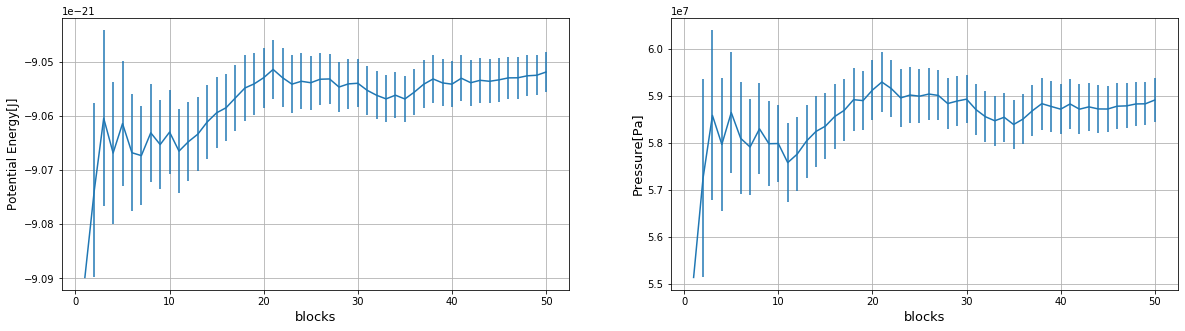

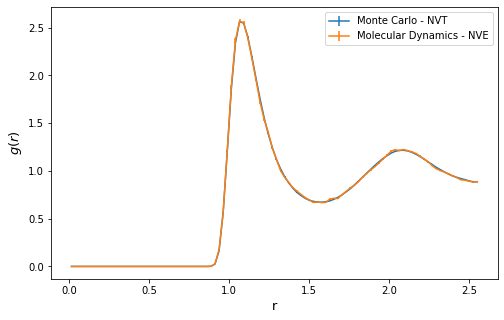

In [4]:
(blk, Epot_l, errEpot_l) = np.loadtxt('MonteCarlo_NVT/liquid/output.epot.0', unpack=True, usecols=(0, 2, 3))
Epot_l = Epot_l*epsilon
errEpot_l = errEpot_l*epsilon

(blk, Pres_l, errPres_l) = np.loadtxt('MonteCarlo_NVT/liquid/output.pres.0', unpack=True, usecols=(0, 2, 3))
Pres_l = Pres_l*fatt_pres
errPres_l = errPres_l*fatt_pres

(r_l, gdir_l, errGdir_l) = np.loadtxt('MonteCarlo_NVT/liquid/output.gave.0', unpack=True, usecols=(1, 2, 3))
(r_l_MD, gdir_l_MD, errGdir_l_MD) = np.loadtxt('../Exercise04/MolecularDynamics_NVE/liquid/ave_gave.dat', unpack=True, usecols=(1, 2, 3))

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].errorbar(blk, Epot_l, yerr=errEpot_l)
axs[0].set_ylabel('Potential Energy[J]', fontsize=12)
axs[1].errorbar(blk, Pres_l, yerr=errPres_l)
axs[1].set_ylabel('Pressure[Pa]', fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('blocks', fontsize=13)
    ax.grid()

plt.figure(figsize=(8, 5))
plt.errorbar(r_l, gdir_l, yerr=errGdir_l, label = 'Monte Carlo - NVT')
plt.errorbar(r_l_MD, gdir_l_MD, yerr=errGdir_l_MD, label = 'Molecular Dynamics - NVE')
plt.ylabel('$g(r)$', fontsize=13)
plt.xlabel('r', fontsize=13)
plt.legend()
plt.show()

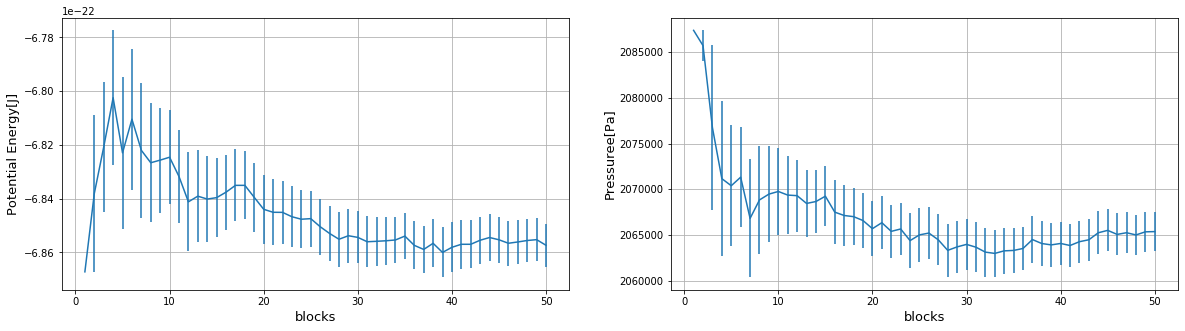

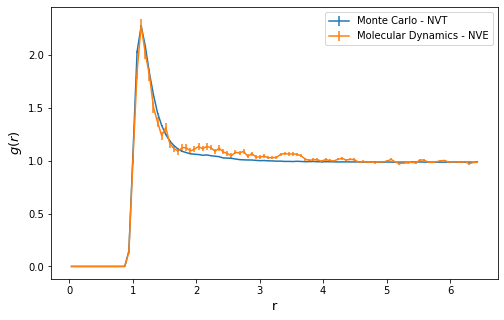

In [5]:
(blk, Epot_g, errEpot_g) = np.loadtxt('MonteCarlo_NVT/gas/output.epot.0', unpack=True, usecols=(0, 2, 3))
Epot_g = Epot_g*epsilon
errEpot_g = errEpot_g*epsilon

(blk, Pres_g, errPres_g) = np.loadtxt('MonteCarlo_NVT/gas/output.pres.0', unpack=True, usecols=(0, 2, 3))
Pres_g = Pres_g*fatt_pres
errPres_g = errPres_g*fatt_pres

(r_g, gdir_g, errGdir_g) = np.loadtxt('MonteCarlo_NVT/gas/output.gave.0', unpack=True, usecols=(1, 2, 3))
(r_g_MD, gdir_g_MD, errGdir_g_MD) = np.loadtxt('../Exercise04/MolecularDynamics_NVE/gas/ave_gave.dat', unpack=True, usecols=(1, 2, 3))

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].errorbar(blk, Epot_g, yerr=errEpot_g)
axs[0].set_ylabel('Potential Energy[J]', fontsize=13)
axs[1].errorbar(blk, Pres_g, yerr=errPres_g)
axs[1].set_ylabel('Pressuree[Pa]', fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('blocks', fontsize=13)
    ax.grid()

plt.figure(figsize=(8, 5))
plt.errorbar(r_g, gdir_g, yerr=errGdir_g, label = 'Monte Carlo - NVT')
plt.errorbar(r_g_MD, gdir_g_MD, yerr=errGdir_g_MD, label = 'Molecular Dynamics - NVE')
plt.ylabel('$g(r)$', fontsize=13)
plt.xlabel('r', fontsize=13)
plt.legend()
plt.show()